# Modern Monte Carlo Tree Search

How can we efficiently search without relying on expert knowledge?

- **exploration**: learn values of actions we are uncertain about
- **exploitation**: focus search on promising parts of tree



## Multi-Armed bandit

- MDP with no state
- we want to minimize the total regret (how much reward you lost by not selecting optimal action up to time T)

- **information state search**: exploration provides information which can increase expected reward in future 
- optimal solutions can be found by solving infinte-state MDP over info states
- need heuristics to make things tractable

bandit strategies scale with how we handle uncertainty:

- no exploration, just greedily pull best values we have seen in past
- random exploration
- explore with preference towards uncertaint



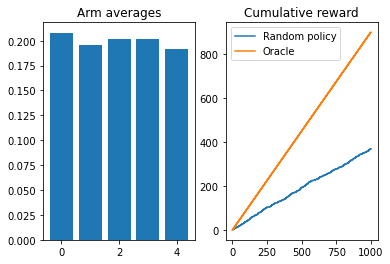

In [64]:
import gym
import numpy as np
import matplotlib.pyplot as plt

class Bandit(gym.Env):

    def __init__(self, config):
        self.n_arms = config["num_arms"]
        self.probs = config["probs"]

        assert len(self.probs) == self.n_arms

        self.cumulative_reward = np.zeros(self.n_arms)
        self.visits = np.zeros(self.n_arms)
    
    
    def step(self, action):
        assert action < self.n_arms and action >= 0
        self.visits[action] += 1

        if np.random.random() < self.probs[action]:
            self.cumulative_reward[action] += 1
            return 1
        
        return 0
    
    def arm_avgs(self):
        return self.cumulative_reward / (np.linalg.norm(self.cumulative_reward) + 0.000001)

    def reset(self):
        self.cumulative_reward = np.zeros(self.n_arms)
    
    def seed(self, seed):
        np.random.seed(seed)




config = {"num_arms" : 5, "probs": [0.1, 0.2, 0.3, 0.4, 0.9]}
env = Bandit(config)
env.seed(1)

r_random = np.zeros(1000)
for t in range(1000):
    r_random[t] = env.step(np.random.randint(5))

fig, axs = plt.subplots(1,2)
axs[0].bar(range(5),env.visits / env.visits.sum())
axs[0].set_title("Arm averages")

steps = np.arange(1000)
axs[1].set_title("Cumulative reward")
axs[1].step(steps, np.cumsum(r_random), label="Random policy")
axs[1].step(steps, 0.9 * steps, label="Oracle")
axs[1].legend()
plt.show()

     


### $\epsilon$-Greedy Algorithm

action value is just average of rewards we have seen over time

e-Greedy just selects the non-max at random sometimes


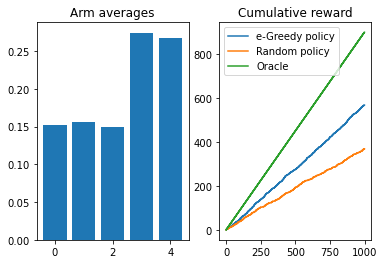

In [66]:
config = {"num_arms" : 5, "probs": [0.1, 0.2, 0.3, 0.4, 0.9]}

env.reset()

epsilon = 0.6
r_greedy = np.zeros(1000)
for t in range(1000):
    avgs = env.arm_avgs()
    if np.random.random() < epsilon:
        r_greedy[t] = env.step(np.random.randint(5))
    else:
        r_greedy[t] = env.step(np.argmax(avgs))

fig, axs = plt.subplots(1,2)
axs[0].bar(range(5), env.visits / env.visits.sum())
axs[0].set_title("Arm averages")

steps = np.arange(1000)
axs[1].set_title("Cumulative reward")
axs[1].step(steps, np.cumsum(r_greedy), label="e-Greedy policy")
axs[1].step(steps, np.cumsum(r_random), label="Random policy")
axs[1].step(steps, 0.9 * steps, label="Oracle")
axs[1].legend()
plt.show()

### UCB Algorithm

e-Greedy not awesome because a lot of the time we end up exploring bad actions that we sort of know will not yield anything great

The idea is to agument the value function with an upper bound on the reward value so that the true reward value is lower: $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$.

Hoeffding's inequality can be used if we do not want to assign any prior to the distribution of rewards, works for any bounded distribution. 

$$P[\frac{1}{n} \sum_{i =1}^{n}(Z_i - E[Z_i]) \geq \delta\ ] \leq e^{- \frac{2n\delta^2}{(b - a)^2}}$$

So we view this average of the random variable $Z_i$ as the averaged reward of a particular action, $\hat{Q_t}(a) = \frac{1}{n} \sum_{t=0}^n R_i$. The inequality then gets written as (with $t = N_t(a)$, the number of times this action has been visited): 

$$P[Q_t - \hat{Q_t} \geq \delta ] \leq e^{-\frac{2N_t(a)\delta^2}{(b-a)^2}}$$

We see that then our upper bound on the true reward can be given by $\delta = \hat{U_t}(a)$. And if we make the simplifying assumption that the reward is bounded to be on the interval $(0, 1)$. We can then for any value of the probability of deviation, $p$, we can solve for what we expect the upper bound on that deviation to be:

$$
p \approx e^{-2N_t(a)U_t(a)^2} \\
U_t(a) = \sqrt{\frac{- \log p}{2 N_t (a)}}
$$

### UCB 1
Most of the time when we see the UCB algorithm in practice (like monte carlo tree search), we see it in the guise of 
### 

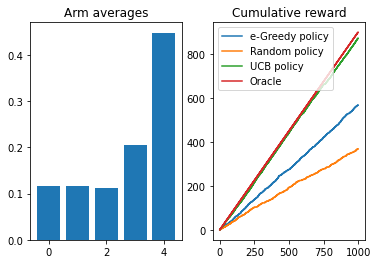

In [72]:
config = {"num_arms" : 5, "probs": [0.1, 0.2, 0.3, 0.4, 0.9]}

epsilon = 0.6
r_ucb = np.zeros(1000)
for t in range(1000):
    avgs = env.arm_avgs() + np.sqrt((2 * np.log(t)) / env.cumulative_reward)
    r_ucb[t] = env.step(np.argmax(avgs))

fig, axs = plt.subplots(1,2)
cr = env.cumulative_reward
axs[0].bar(range(5), env.visits / env.visits.sum())
axs[0].set_title("Arm averages")

steps = np.arange(1000)
axs[1].set_title("Cumulative reward")
axs[1].step(steps, np.cumsum(r_greedy), label="e-Greedy policy")
axs[1].step(steps, np.cumsum(r_random), label="Random policy")
axs[1].step(steps, np.cumsum(r_ucb), label="UCB policy")
axs[1].step(steps, 0.9 * steps, label="Oracle")
axs[1].legend()
plt.show()